# Analysis of Customer Churn

## Background

The nature and magnitude of marketing has changed radically in the digital age which creates a challenge for companies. The nature of customer retention has evolved because customers now have more options and information available to them i.e. customers are exposed to similar products offering similar perks at a high frequency. Companies now pay a great deal of attention and invest a lot in customer retention because it costs more to solve this problem and perhaps the most efficient method of addressing this issue is to use predictive modelling to determine customers who are likely to churn and develop specially tailored customer retention programs.


In [ ]:
# import relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
sns.set(style="ticks", color_codes=True)
pd.set_option('display.max_columns', None)

## Data

Telco Data from IBM Watson website turned into a Kaggle competition. Each row represents a unique customer. The 'churn' column has 2 values 1 and 0 where 1 indicates a customerwho churned.

In [2]:
df = pd.read_csv('Telco_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.shape

(7043, 21)

In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
df = df[df['TotalCharges'] != ' ']
#df.TotalCharges = df.TotalCharges.astype('float')

In [6]:
df.shape

(7032, 21)

In [7]:
df.TotalCharges = df.TotalCharges.astype('float')

In [8]:
df.SeniorCitizen = df.SeniorCitizen.astype('category')

In [9]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


## Preprocessing
First step is to separate the customers into two groups, customer_ret which represents retained cusomers and customer_att which represents customers that churned.

In [10]:
customer_ret = df[df['Churn'] == "No"]
customer_att = df[df['Churn'] == "Yes"]

In [11]:
customer_ret.describe()

,tenure,MonthlyCharges,TotalCharges
count,5163.00000,5163.000000,5163.000000
mean,37.65001,61.307408,2555.344141
std,24.07694,31.094557,2329.456984
min,1.00000,18.250000,18.800000
25%,15.00000,25.100000,577.825000
50%,38.00000,64.450000,1683.600000
75%,61.00000,88.475000,4264.125000
max,72.00000,118.750000,8672.450000


In [12]:
customer_att.describe()

,tenure,MonthlyCharges,TotalCharges
count,1869.000000,1869.000000,1869.000000
mean,17.979133,74.441332,1531.796094
std,19.531123,24.666053,1890.822994
min,1.000000,18.850000,18.850000
25%,2.000000,56.150000,134.500000
50%,10.000000,79.650000,703.550000
75%,29.000000,94.200000,2331.300000
max,72.000000,118.350000,8684.800000


## Exploratory Data Analysis

In this step I investigated nuances in the dataset to find insights about the customers that could affect their likelihood of Churn

In [13]:
customer_att.groupby(['tenure', 'MultipleLines'])['MonthlyCharges'].sum()

tenure  MultipleLines   
1       No                  15882.65
        No phone service     1213.15
        Yes                  5019.20
2       No                   5187.45
        No phone service      481.30
                              ...   
70      Yes                   919.35
71      No phone service       49.35
        Yes                   521.45
72      No phone service       54.20
        Yes                   527.05
Name: MonthlyCharges, Length: 186, dtype: float64

In [14]:
df.InternetService.unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [15]:
df.InternetService.value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

In [16]:
df.groupby(['InternetService', 'PhoneService']).size()

InternetService  PhoneService
DSL              No               680
                 Yes             1736
Fiber optic      Yes             3096
No               Yes             1520
dtype: int64

In [17]:
customer_att.groupby(['InternetService', 'PhoneService']).size()

InternetService  PhoneService
DSL              No               170
                 Yes              289
Fiber optic      Yes             1297
No               Yes              113
dtype: int64

In [18]:
customer_ret.groupby(['InternetService', 'PhoneService']).size()

InternetService  PhoneService
DSL              No               510
                 Yes             1447
Fiber optic      Yes             1799
No               Yes             1407
dtype: int64

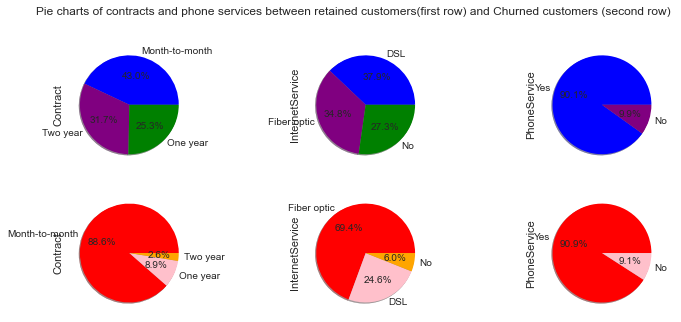

In [19]:
dims = (12, 5)
fig, ax =plt.subplots(2,3,figsize=dims)
plt.suptitle('Pie charts of contracts and phone services between retained customers(first row) and Churned customers (second row) ')
#loyal customers
customer_ret.Contract.value_counts().plot(kind='pie',shadow=True,autopct='%1.1f%%', ax=ax[0,0], colors = ['blue', 'purple', 'green'])
customer_ret.InternetService.value_counts().plot(kind='pie',shadow=True,autopct='%1.1f%%', ax=ax[0,1], colors = ['blue', 'purple', 'green'])
customer_ret.PhoneService.value_counts().plot(kind='pie',shadow=True,autopct='%1.1f%%', ax=ax[0,2], colors = ['blue', 'purple', 'green'])
#disloyal customers
customer_att.Contract.value_counts().plot(kind='pie',shadow=True,autopct='%1.1f%%', ax=ax[1,0], colors = ['red', 'pink', 'orange'])
customer_att.InternetService.value_counts().plot(kind='pie',shadow=True,autopct='%1.1f%%', ax=ax[1,1], colors = ['red', 'pink', 'orange'])
customer_att.PhoneService.value_counts().plot(kind='pie',shadow=True,autopct='%1.1f%%', ax=ax[1,2], colors = ['red', 'pink', 'orange'])
plt.savefig('services and contracts.jpg')

In [20]:
customer_ret.groupby(['InternetService', 'PhoneService'])['TotalCharges'].sum()

InternetService  PhoneService
DSL              No               903490.00
                 Yes             3857904.35
Fiber optic      Yes             7440365.50
No               Yes              991481.95
Name: TotalCharges, dtype: float64

In [21]:
customer_att.groupby(['InternetService', 'PhoneService'])['TotalCharges'].sum()

InternetService  PhoneService
DSL              No               116804.95
                 Yes              243211.55
Fiber optic      Yes             2483257.45
No               Yes               19652.95
Name: TotalCharges, dtype: float64

In [22]:
customer_att.groupby(['InternetService', 'PhoneService'])['MonthlyCharges'].sum()

InternetService  PhoneService
DSL              No                6380.75
                 Yes              16148.45
Fiber optic      Yes             114300.05
No               Yes               2301.60
Name: MonthlyCharges, dtype: float64

In [23]:
customer_ret.groupby(['InternetService', 'PhoneService'])['MonthlyCharges'].sum()

InternetService  PhoneService
DSL              No               22174.15
                 Yes              95637.30
Fiber optic      Yes             168984.35
No               Yes              29734.35
Name: MonthlyCharges, dtype: float64

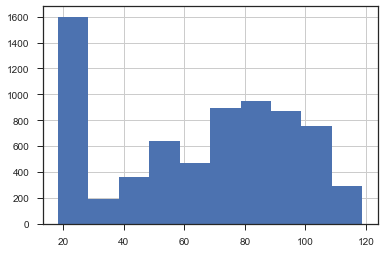

In [24]:
df['MonthlyCharges'].hist()

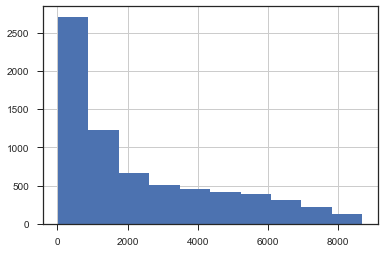

In [25]:
df['TotalCharges'].hist()

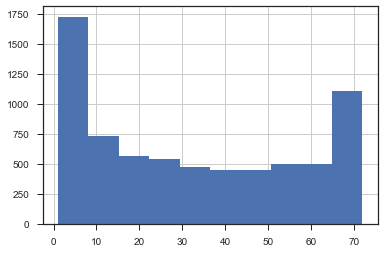

In [26]:
df['tenure'].hist()

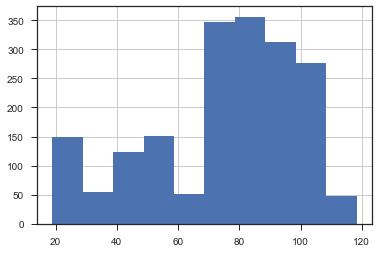

In [27]:
customer_att['MonthlyCharges'].hist()

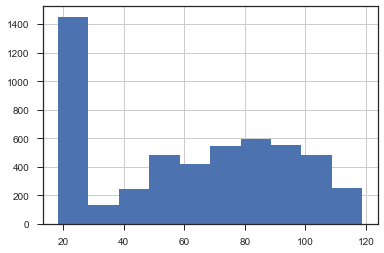

In [28]:
customer_ret['MonthlyCharges'].hist()

Text(0.5, 0.98, 'Churned (Red) v Retained customer (Green)')

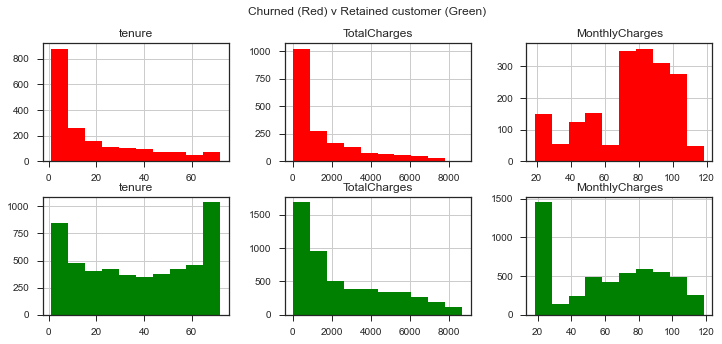

In [29]:
dims = (12, 5)
fig, ax =plt.subplots(2,3,figsize=dims)
customer_att.hist(column= 'tenure', ax=ax[0,0], color='red')
customer_att.hist(column = 'TotalCharges', ax=ax[0,1], color='red')
customer_att.hist(column= 'MonthlyCharges', ax=ax[0,2], color='red')
             
customer_ret.hist(column= 'tenure', ax=ax[1,0], color='green')
customer_ret.hist(column= 'TotalCharges', ax=ax[1,1], color='green')
customer_ret.hist(column= 'MonthlyCharges', ax=ax[1,2], color='green') 
plt.suptitle('Churned (Red) v Retained customer (Green)')

## Get features and target

In [30]:
X = df.drop(columns=['customerID','Churn'])
y = df['Churn']

## Encode categorical features

In [31]:
# Encode the features using One-hot-encoding
X = pd.get_dummies(data=X)

# Get the name of the feature-value pairs
feature_value_names = X.columns

## Encode the target

In [32]:
le = LabelEncoder()
y = le.fit_transform(y)

pd.DataFrame(data=y, columns=['Churn'])['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

## Divide the data into training and test sets

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Create pipelines for Model
This step standardizes the features before going into the model

In [34]:
pipe_dt = Pipeline([('StandardScaler', StandardScaler()), ('DecisionTreeClassifier', DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)


C:\Users\Aluya\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Aluya\Anaconda\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('DecisionTreeClassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [35]:
pipe_rf = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier())])

pipe_rf.fit(X, y)

C:\Users\Aluya\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Aluya\Anaconda\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Aluya\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

## Get feature importance using random forest

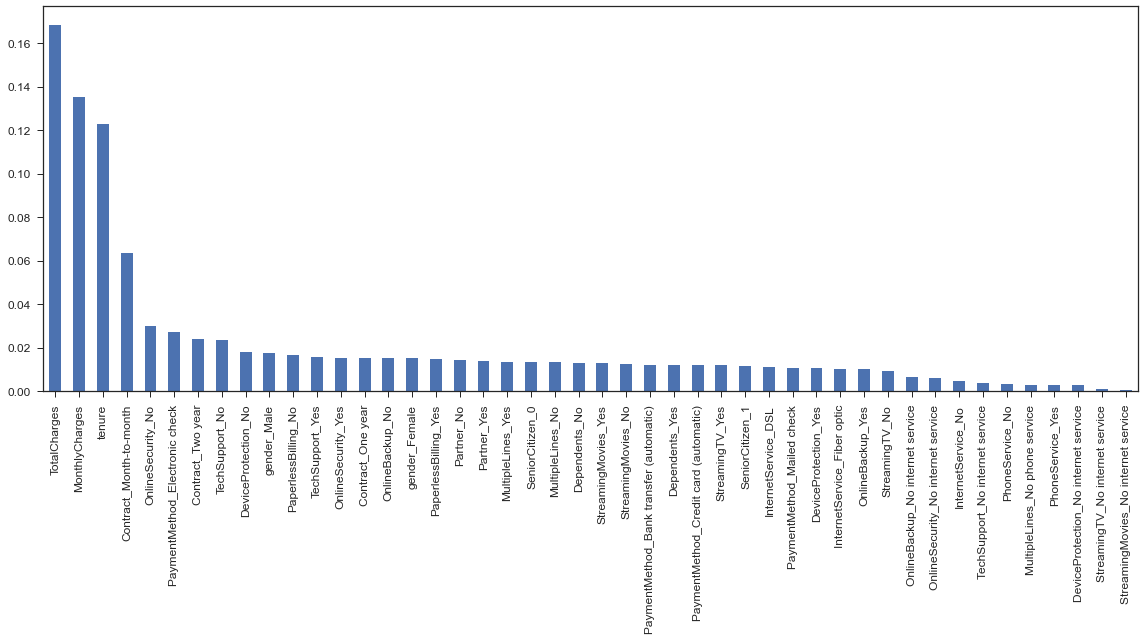

In [36]:
# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(pipe_rf.named_steps['RandomForestClassifier'].feature_importances_, feature_value_names)

# Sort the array in descending order of the importances
f_importances = f_importances.sort_values(ascending=False)

# Draw the bar Plot from f_importances 
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=90, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Create dictionary of classifiers

In [37]:
clfs = {'lr': LogisticRegression(random_state=0),
        'dt': DecisionTreeClassifier(random_state=0),
        'rf': RandomForestClassifier(random_state=0),
        'knn': KNeighborsClassifier(),
        'gnb': GaussianNB()}

In [38]:
pipe_clfs = {}

for name, clf in clfs.items():
    # Implement me
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

## Create dictionary of parameter grids

In [39]:
param_grids = {}

In [40]:
C_range = [10 ** i for i in range(-4, 5)]

param_grid = [{'clf__multi_class': ['ovr'], 
               'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'clf__C': C_range},
              
              {'clf__multi_class': ['multinomial'],
               'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'clf__C': C_range}]

# Implement me
param_grids['lr'] = param_grid

In [41]:
param_grid = [{'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

# Implement me
param_grids['dt'] = param_grid

In [42]:
param_grid = [{'clf__n_estimators': [2, 10, 30],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

# Implement me
param_grids['rf'] = param_grid

In [43]:
param_grid = [{'clf__n_neighbors': list(range(1, 11))}]

# Implement me
param_grids['knn'] = param_grid

In [44]:
param_grid = [{'clf__var_smoothing': [10 ** i for i in range(-10, -7)]}]

# Implement me
param_grids['gnb'] = param_grid

In [45]:
import warnings
warnings.filterwarnings('ignore')

## Hyperparameter Tuning

In [46]:
# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

# For each classifier
for name in pipe_clfs.keys():
    # GridSearchCV
    # Implement me
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=10,
                                         shuffle=True,
                                         random_state=0))
    # Fit the pipeline
    # Implement me
    gs = gs.fit(X, y)
    
    # Update best_score_param_estimators
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

## Model Selection

In [47]:
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# For each [best_score_, best_params_, best_estimator_]
for best_score_param_estimator in best_score_param_estimators:
    # Print out [best_score_, best_params_, best_estimator_], where best_estimator_ is a pipeline
    # Since we only print out the type of classifier of the pipeline
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[0.8056029579067122, {'clf__min_samples_leaf': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 30}, <class 'sklearn.ensemble.forest.RandomForestClassifier'>]

[0.8034698521046644, {'clf__C': 10, 'clf__multi_class': 'ovr', 'clf__solver': 'sag'}, <class 'sklearn.linear_model.logistic.LogisticRegression'>]

[0.7844141069397043, {'clf__min_samples_leaf': 30, 'clf__min_samples_split': 2}, <class 'sklearn.tree.tree.DecisionTreeClassifier'>]

[0.7717576791808873, {'clf__n_neighbors': 10}, <class 'sklearn.neighbors.classification.KNeighborsClassifier'>]

[0.6958191126279863, {'clf__var_smoothing': 1e-10}, <class 'sklearn.naive_bayes.GaussianNB'>]



In [48]:
print('Accuracy:', end=' ')
# Implement me
print(best_score_param_estimators[0][2].score(X_test, y_test))

Accuracy: 0.8329779673063256


In [49]:
# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# Print out best_estimator
print(best_score_param_estimators[0][2])

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=Non...imators=30, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])


In [50]:
thresholds = [0, 0.125, 0.25, 0.375]

In [51]:
for name, clf in clfs.items():
    pipe_clfs[name] = {}
    
    for threshold in thresholds:
        pipe_clfs[name][threshold] = Pipeline([('StandardScaler', StandardScaler()),
                                               ('SelectFromModel', SelectFromModel(estimator=RandomForestClassifier(random_state=0), threshold=threshold)),
                                               ('clf', clf)])

In [52]:
for best_score_param_estimator in best_score_param_estimators:
    if (isinstance(best_score_param_estimator[2].named_steps['clf'], RandomForestClassifier) is True
        and len(best_score_param_estimator[2].named_steps['clf'].feature_importances_) == len(feature_value_names)):
        best_rfc = best_score_param_estimator[2].named_steps['clf']
        break

# Get the importances obtained by best_rfc
# Implement me
importances = best_rfc.feature_importances_

# Convert the importances into pandas series
f_importances = pd.Series(importances, feature_value_names)

# Sort the series in descending order of the importances
f_importances = f_importances.sort_values(ascending=False)

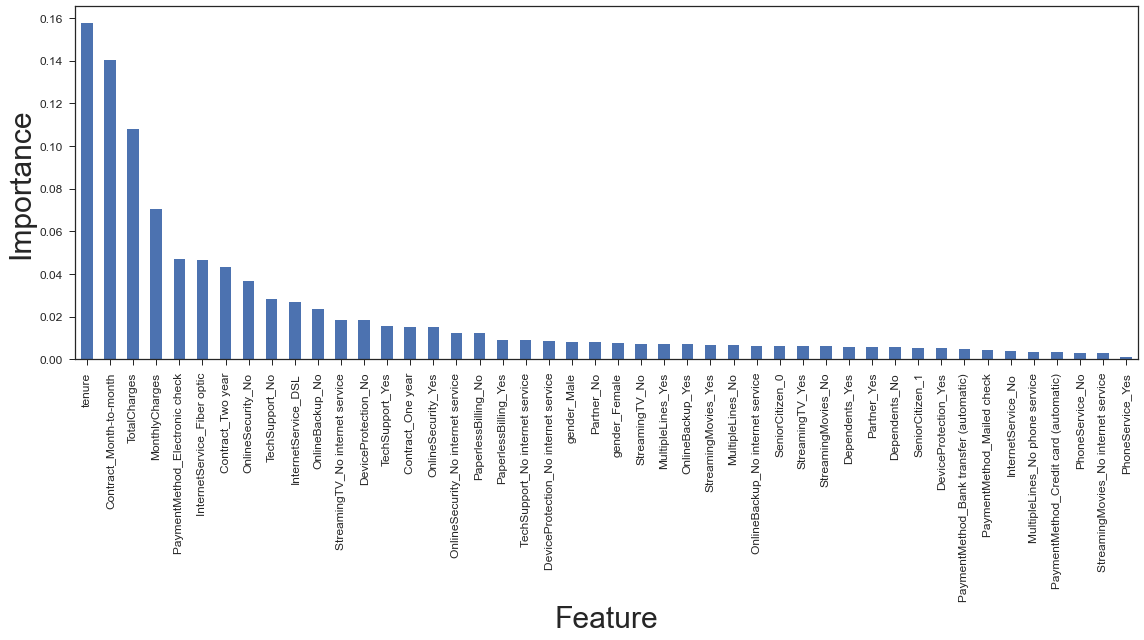

In [53]:
# Draw the bar plot
ax = f_importances.plot(kind='bar', figsize=(16,9), rot=90, fontsize=12)
ax.set_xlabel('Feature', fontsize=30)
ax.set_ylabel('Importance', fontsize=30)

# Show the plot
plt.tight_layout()
plt.show()

In [54]:
mod = pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
conf_mat = cm(y_test, y_pred)

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1038
           1       0.63      0.44      0.52       369

   micro avg       0.79      0.79      0.79      1407
   macro avg       0.73      0.67      0.69      1407
weighted avg       0.77      0.79      0.77      1407



In [56]:
y_pred1 = pipe_dt.predict(X_test)
conf_mat1 = cm(y_test, y_pred1)

In [57]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1038
           1       0.46      0.48      0.47       369

   micro avg       0.72      0.72      0.72      1407
   macro avg       0.64      0.64      0.64      1407
weighted avg       0.72      0.72      0.72      1407



In [58]:
pipe_lr = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', LogisticRegression())])

pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RandomForestClassifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [59]:
y_pred2 = pipe_lr.predict(X_test)
conf_mat2 = cm(y_test, y_pred2)

In [60]:
conf_mat2

array([[933, 105],
       [166, 203]], dtype=int64)

In [61]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1038
           1       0.66      0.55      0.60       369

   micro avg       0.81      0.81      0.81      1407
   macro avg       0.75      0.72      0.74      1407
weighted avg       0.80      0.81      0.80      1407



In [62]:
pipe_knn = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', KNeighborsClassifier())])

pipe_knn.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RandomForestClassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

In [63]:
y_pred3 = pipe_knn.predict(X_test)
conf_mat3 = cm(y_test, y_pred3)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1038
           1       0.54      0.51      0.52       369

   micro avg       0.76      0.76      0.76      1407
   macro avg       0.68      0.68      0.68      1407
weighted avg       0.75      0.76      0.75      1407



In [64]:
pipe_NB = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', GaussianNB())])

pipe_NB.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RandomForestClassifier', GaussianNB(priors=None, var_smoothing=1e-09))])

In [65]:
y_pred4 = pipe_NB.predict(X_test)
conf_mat3 = cm(y_test, y_pred4)
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1038
           1       0.46      0.85      0.60       369

   micro avg       0.70      0.70      0.70      1407
   macro avg       0.69      0.75      0.68      1407
weighted avg       0.80      0.70      0.72      1407



In [66]:
#! pip install ggplot2

ERROR: Could not find a version that satisfies the requirement ggplot2 (from versions: none)
ERROR: No matching distribution found for ggplot2
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [67]:
#! pip install --upgrade pip

ERROR: To modify pip, please run the following command:
c:\users\aluya\anaconda\python.exe -m pip install --upgrade pip
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [68]:
#! pip install ggplot

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


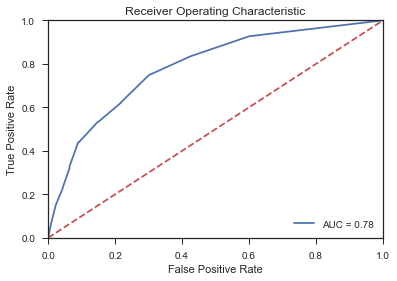

In [71]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = pipe_rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
#from ggplot import *
#df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
#ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

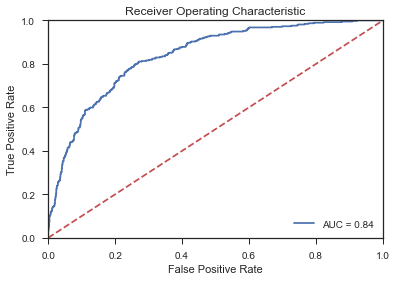

In [73]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = pipe_lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
#from ggplot import *
#df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
#ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

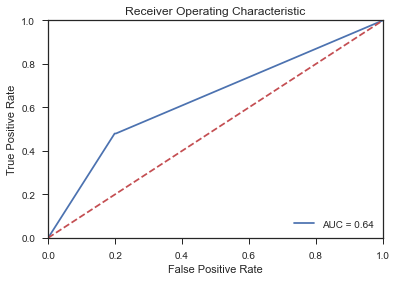

In [74]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = pipe_dt.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
#from ggplot import *
#df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
#ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

# Conclusion

The logistic regression model retrns the best results. This exercise shows us how to fine tune not only the hyperparameter of an estimator (i.e., classifier), using Pipeline and GridSearchCV. 